In [1]:
import matplotlib.pyplot as plt
import numpy as np
import obspy
from obspy.core.trace import Trace, Stats
from obspy.core.stream import Stream
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

client = Client("IRIS")

def waveforms(start, end, adjtime):
    st = client.get_waveforms("XB", "ELYSE", "02", "B*", start-adjtime, end+adjtime)
    st.detrend(type='simple')
    return st

def uvw2enz(st):
    if len(st) != 3:
       print('Stream does not contain 3 Traces')
       return st
    for trace in st:
        head = trace.stats
        channel = head.channel
        if channel == 'BHU': U = trace.data
        elif channel == 'BHV': V = trace.data
        elif channel == 'BHW': W = trace.data
        else:
            print('Trace.channel is not BHU, BHV, or BHW')
            return st

    d = np.radians(-30)
    aU = np.radians(135)
    aV = np.radians(15)
    aW = np.radians(255)

    A = np.array([[np.cos(d)*np.sin(aU), np.cos(d)*np.cos(aU),-np.sin(d)],
                  [np.cos(d)*np.sin(aV), np.cos(d)*np.cos(aV), -np.sin(d)],
                  [np.cos(d)*np.sin(aW), np.cos(d)*np.cos(aW), -np.sin(d)]])

    B = np.linalg.inv(A)
    E,N,Z = np.dot(B,(U,V,W))

    head.channel = 'BHE'; trE = Trace(data=E, header=head)
    head.channel = 'BHN'; trN = Trace(data=N, header=head)
    head.channel = 'BHZ'; trZ = Trace(data=Z, header=head)
    stENZ = Stream(traces=[trE,trN,trZ])

    return stENZ

In [2]:
def rotate(c1,c2,a):
    """
    IN: c1,c2 (arrays) and a (angle)
    c1 c2 are the X and Y axes, respectively of a Cartesian coordinate system
    a is an angle in degrees, positive angle means a clockwise rotation of the coordinate system.
    OUT: o1, o2 (arrays)
    o1 o2 are the X and Y axes, respectively of a rotated Cartesian coordinate system
    """
    o1 = np.cos(np.radians(a))*c1 - np.sin(np.radians(a))*c2
    o2 = np.sin(np.radians(a))*c1 + np.cos(np.radians(a))*c2
    return o1, o2

# S0235b

In [ ]:
begin = UTCDateTime('2019-07-26T12:19:18')  # p-wave arrival
end = UTCDateTime('2019-07-26T12:22:05')    # s-wave arrival

st_uvw = waveforms(begin, end, 600)
st_z12 = uvw2enz(st_uvw)

stf = st_z12.copy()
stf.filter('bandpass', freqmin = 0.125, freqmax = 1.0, corners=4, zerophase=True)

In [ ]:
stP = stf.slice(starttime=begin-1,endtime=begin+2)
stS = stf.slice(starttime=end-5, endtime=end+15)
print(stP)
print(stS)

In [ ]:
scale = 1/200
hhe = scale * stP[0].data
hhn = scale * stP[1].data

tvall = []
alpha = np.arange(0,360,1)

# calculate Energy on channels oriented in the a direction, for all a in alpha:
# angle a is relative to orientation of channels 1 and 2.
# c1 is the x-axis, c2 is the y-axis
for a in alpha:
    hhT,hhR = rotate(hhe,hhn,a)
    Tenergy = np.dot(hhT,hhT)
    tvall.append(Tenergy)
    
tval = np.array(tvall) 
mina = alpha[np.argmin(tval)]

mina_guess = tval[np.where(alpha == mina)]
mina_74 = tval[np.where(alpha == 74)]
print(mina_74, mina_guess)

#angle at which the energy is minimized
print('optimal angle = ',mina,' or ',mina-180)
thetat = str(mina); thetalt = str(mina-180)

#reported as 74

In [ ]:
hhe = stS[0].data
hhn = stS[1].data
hhT,hhR = rotate(hhe,hhn,252)

streamRT = stS.copy()
streamRT[0].data = hhT
streamRT[1].data = hhR
streamRT[0].stats.component = 'T'
streamRT[1].stats.component = 'R'

streamRT.plot();

# S0173a

In [3]:
begin = UTCDateTime('2019-05-23T02:22:59')  # p-wave arrival
end = UTCDateTime('2019-05-23T02:25:53')    # s-wave arrival

st_uvw = waveforms(begin, end, 600)
st_z12 = uvw2enz(st_uvw)
    
stf = st_z12.copy()
stf.filter('bandpass', freqmin = 0.125, freqmax = 1.0, corners=4, zerophase=True)

3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-05-23T02:12:59.031000Z - 2019-05-23T02:35:52.981000Z | 20.0 Hz, 27480 samples
XB.ELYSE.02.BHN | 2019-05-23T02:12:59.031000Z - 2019-05-23T02:35:52.981000Z | 20.0 Hz, 27480 samples
XB.ELYSE.02.BHZ | 2019-05-23T02:12:59.031000Z - 2019-05-23T02:35:52.981000Z | 20.0 Hz, 27480 samples

In [9]:
stP = stf.slice(starttime=begin-1,endtime=begin+1)
stS = stf.slice(starttime=end-5, endtime=end+1)

stP2 = stf.slice(starttime=begin+3,endtime=begin+8)
stS2 = stf.slice(starttime=end+3,endtime=end+10)
print(stP)
print(stS)

3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-05-23T02:22:57.981000Z - 2019-05-23T02:22:59.981000Z | 20.0 Hz, 41 samples
XB.ELYSE.02.BHN | 2019-05-23T02:22:57.981000Z - 2019-05-23T02:22:59.981000Z | 20.0 Hz, 41 samples
XB.ELYSE.02.BHZ | 2019-05-23T02:22:57.981000Z - 2019-05-23T02:22:59.981000Z | 20.0 Hz, 41 samples
3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-05-23T02:25:47.981000Z - 2019-05-23T02:25:53.981000Z | 20.0 Hz, 121 samples
XB.ELYSE.02.BHN | 2019-05-23T02:25:47.981000Z - 2019-05-23T02:25:53.981000Z | 20.0 Hz, 121 samples
XB.ELYSE.02.BHZ | 2019-05-23T02:25:47.981000Z - 2019-05-23T02:25:53.981000Z | 20.0 Hz, 121 samples


In [10]:
scale = 1/400
hhe = scale * stP[0].data
hhn = scale * stP[1].data

tvall = []
alpha = np.arange(0,360,1)

# calculate Energy on channels oriented in the a direction, for all a in alpha:
# angle a is relative to orientation of channels 1 and 2.
# c1 is the x-axis, c2 is the y-axis
for a in alpha:
    hhT,hhR = rotate(hhe,hhn,a)
    Tenergy = np.dot(hhT,hhT)
    tvall.append(Tenergy)
    
tval = np.array(tvall) 
mina = alpha[np.argmin(tval)]

mina_guess = tval[np.where(alpha == mina)]
mina_91 = tval[np.where(alpha == 91)]
print(mina_91, mina_guess)

#angle at which the energy is minimized
print('optimal angle = ',mina,' or ',mina-180)
thetat = str(mina); thetalt = str(mina-180)

#reported 91 degrees

[ 0.04866369] [ 0.03965657]
optimal angle =  84  or  -96


In [ ]:
hhe = stS[0].data
hhn = stS[1].data
hhT,hhR = rotate(hhe,hhn,266)

streamRT = stS.copy()
streamRT[0].data = hhT
streamRT[1].data = hhR
streamRT[0].stats.component = 'T'
streamRT[1].stats.component = 'R'

streamRT.plot();

# S0173ab

3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-05-23T02:23:01.981000Z - 2019-05-23T02:23:06.981000Z | 20.0 Hz, 101 samples
XB.ELYSE.02.BHN | 2019-05-23T02:23:01.981000Z - 2019-05-23T02:23:06.981000Z | 20.0 Hz, 101 samples
XB.ELYSE.02.BHZ | 2019-05-23T02:23:01.981000Z - 2019-05-23T02:23:06.981000Z | 20.0 Hz, 101 samples
3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-05-23T02:25:55.981000Z - 2019-05-23T02:26:02.981000Z | 20.0 Hz, 141 samples
XB.ELYSE.02.BHN | 2019-05-23T02:25:55.981000Z - 2019-05-23T02:26:02.981000Z | 20.0 Hz, 141 samples
XB.ELYSE.02.BHZ | 2019-05-23T02:25:55.981000Z - 2019-05-23T02:26:02.981000Z | 20.0 Hz, 141 samples


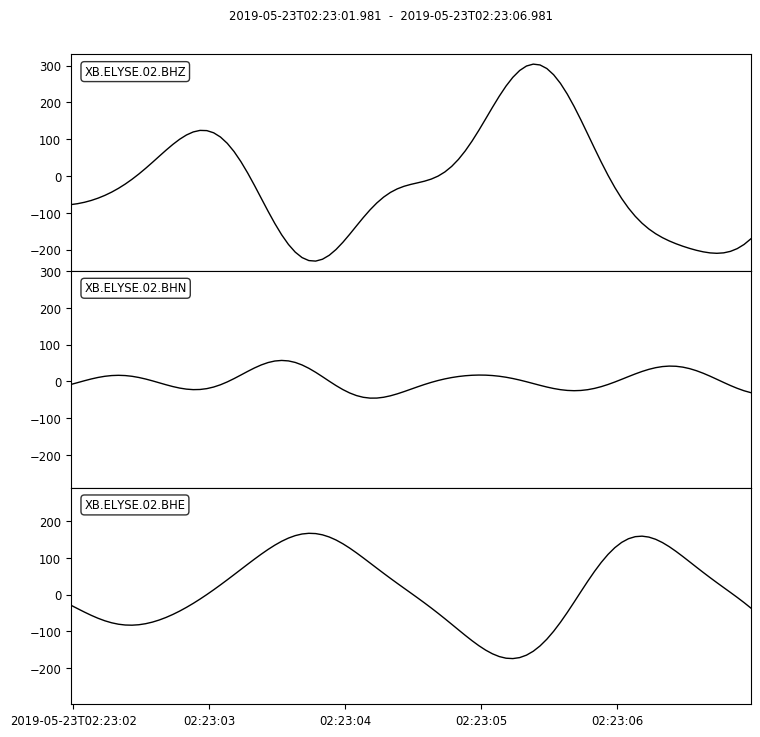

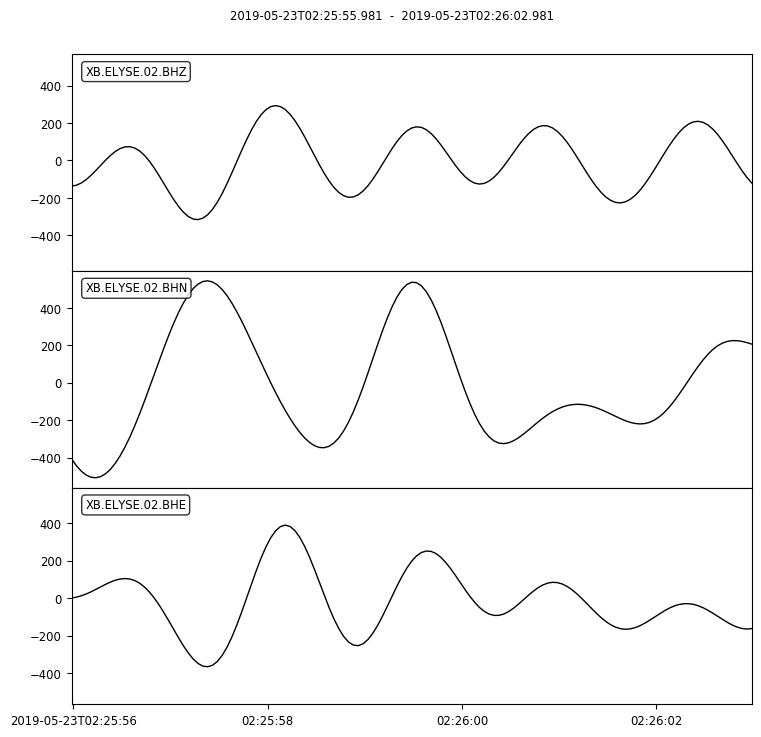

In [21]:
print(stP2)
print(stS2)

stP2.plot();
stS2.plot();

In [17]:
scale = 1/400
hhe = scale * stP2[0].data
hhn = scale * stP2[1].data

tvall = []
alpha = np.arange(0,360,1)

# calculate Energy on channels oriented in the a direction, for all a in alpha:
# angle a is relative to orientation of channels 1 and 2.
# c1 is the x-axis, c2 is the y-axis
for a in alpha:
    hhT,hhR = rotate(hhe,hhn,a)
    Tenergy = np.dot(hhT,hhT)
    tvall.append(Tenergy)
    
tval = np.array(tvall) 
mina = alpha[np.argmin(tval)]

mina_guess = tval[np.where(alpha == mina)]
#mina_91 = tval[np.where(alpha == 91)]
print(mina_guess)

#angle at which the energy is minimized
print('optimal angle = ',mina,' or ',mina-180)
thetat = str(mina); thetalt = str(mina-180)


[ 0.36972729]
optimal angle =  86  or  -94


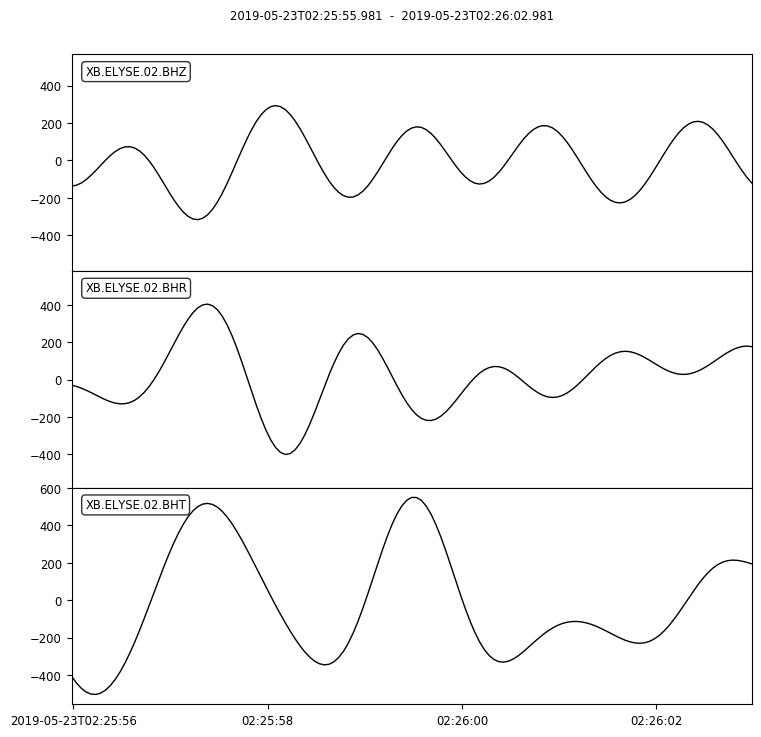

In [20]:
hhe = stS2[0].data
hhn = stS2[1].data
hhT,hhR = rotate(hhe,hhn,266)

streamRT = stS2.copy()
streamRT[0].data = hhT
streamRT[1].data = hhR
streamRT[0].stats.component = 'T'
streamRT[1].stats.component = 'R'

streamRT.plot();

# S0325a

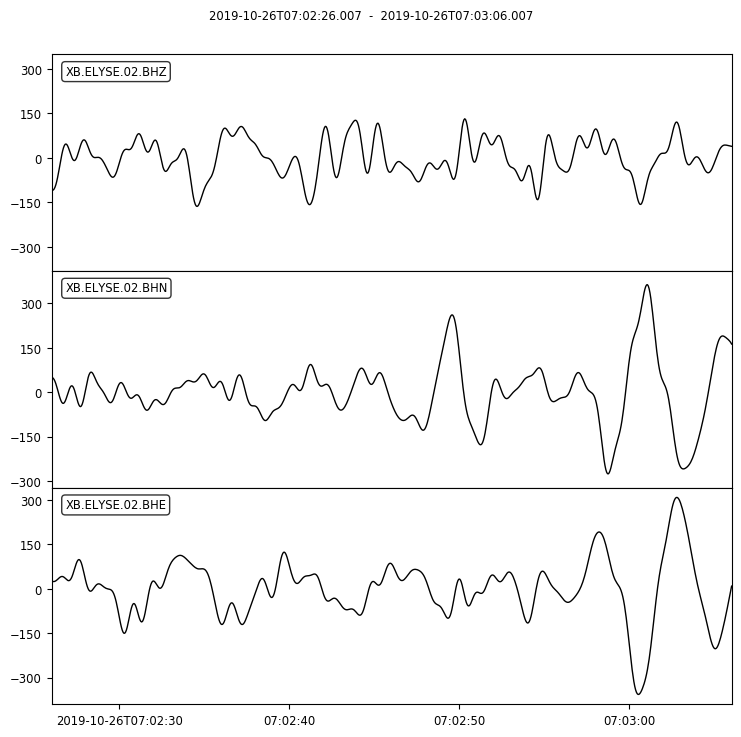

In [30]:
begin = UTCDateTime('2019-10-26T06:58:57')  # p-wave arrival
end = UTCDateTime('2019-10-26T07:02:46')    # s-wave arrival

st_uvw = waveforms(begin, end, 600)
st_z12 = uvw2enz(st_uvw)

stf = st_z12.copy()
stf.filter('bandpass', freqmin = 0.125, freqmax = 1.0, corners=4, zerophase=True)
stzoom = stf.slice(starttime=end-20, endtime=end+20)
stzoom.plot();

In [31]:
stP = stf.slice(starttime=begin-1,endtime=begin+3)
stS = stf.slice(starttime=end-5, endtime=end+15)
print(stP)
print(stS)

3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-10-26T06:58:56.007000Z - 2019-10-26T06:59:00.007000Z | 20.0 Hz, 81 samples
XB.ELYSE.02.BHN | 2019-10-26T06:58:56.007000Z - 2019-10-26T06:59:00.007000Z | 20.0 Hz, 81 samples
XB.ELYSE.02.BHZ | 2019-10-26T06:58:56.007000Z - 2019-10-26T06:59:00.007000Z | 20.0 Hz, 81 samples
3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-10-26T07:02:41.007000Z - 2019-10-26T07:03:01.007000Z | 20.0 Hz, 401 samples
XB.ELYSE.02.BHN | 2019-10-26T07:02:41.007000Z - 2019-10-26T07:03:01.007000Z | 20.0 Hz, 401 samples
XB.ELYSE.02.BHZ | 2019-10-26T07:02:41.007000Z - 2019-10-26T07:03:01.007000Z | 20.0 Hz, 401 samples


In [32]:
scale = 1/200
hhe = scale * stP[0].data
hhn = scale * stP[1].data

tvall = []
alpha = np.arange(0,360,1)

# calculate Energy on channels oriented in the a direction, for all a in alpha:
# angle a is relative to orientation of channels 1 and 2.
# c1 is the x-axis, c2 is the y-axis
for a in alpha:
    hhT,hhR = rotate(hhe,hhn,a)
    Tenergy = np.dot(hhT,hhT)
    tvall.append(Tenergy)
    
tval = np.array(tvall) 
mina = alpha[np.argmin(tval)]

mina_guess = tval[np.where(alpha == mina)]
print(mina_guess)

#angle at which the energy is minimized
print('optimal angle = ',mina,' or ',mina-180)
thetat = str(mina); thetalt = str(mina-180)

[ 0.52475906]
optimal angle =  303  or  123


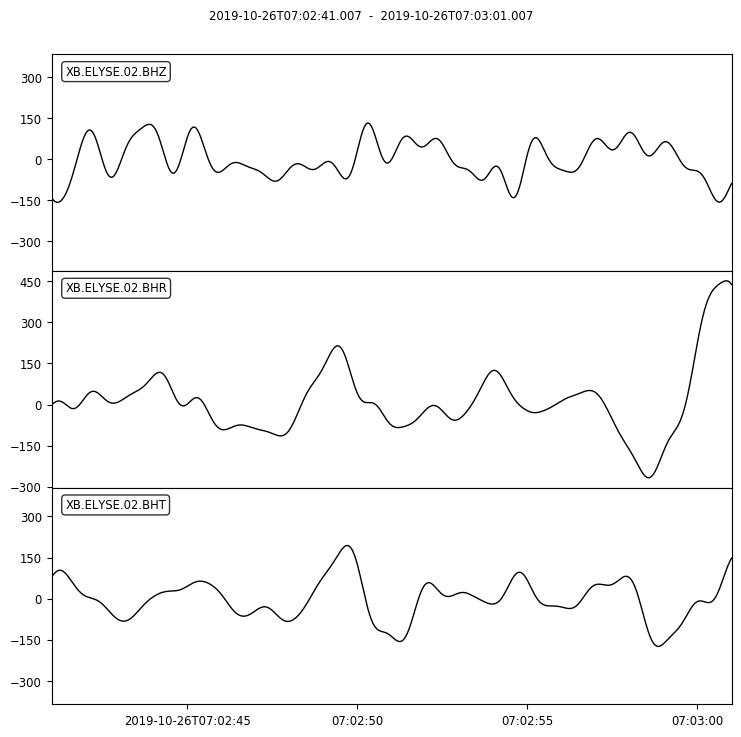

In [33]:
hhe = stS[0].data
hhn = stS[1].data
hhT,hhR = rotate(hhe,hhn,303)

streamRT = stS.copy()
streamRT[0].data = hhT
streamRT[1].data = hhR
streamRT[0].stats.component = 'T'
streamRT[1].stats.component = 'R'

streamRT.plot();

# S0325ab

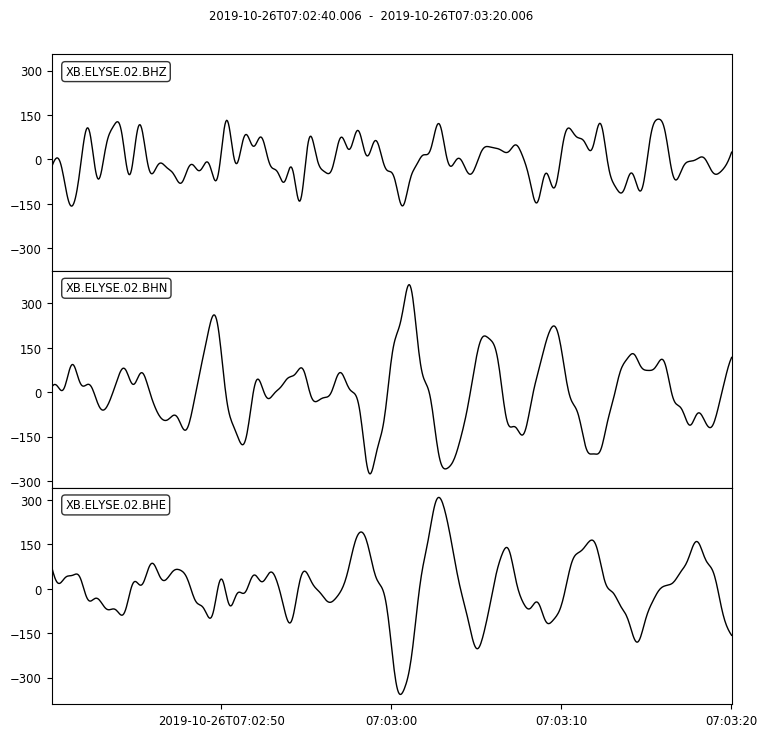

In [26]:
begin = UTCDateTime('2019-10-26T06:59:08')  # p-wave arrival
end = UTCDateTime('2019-10-26T07:03:00')    # s-wave arrival

st_uvw = waveforms(begin, end, 600)
st_z12 = uvw2enz(st_uvw)

stf = st_z12.copy()
stf.filter('bandpass', freqmin = 0.125, freqmax = 1.0, corners=4, zerophase=True)
stzoom = stf.slice(starttime=end-20, endtime=end+20)
stzoom.plot();

3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-10-26T06:59:07.006000Z - 2019-10-26T06:59:11.006000Z | 20.0 Hz, 81 samples
XB.ELYSE.02.BHN | 2019-10-26T06:59:07.006000Z - 2019-10-26T06:59:11.006000Z | 20.0 Hz, 81 samples
XB.ELYSE.02.BHZ | 2019-10-26T06:59:07.006000Z - 2019-10-26T06:59:11.006000Z | 20.0 Hz, 81 samples
3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-10-26T07:02:55.006000Z - 2019-10-26T07:03:15.006000Z | 20.0 Hz, 401 samples
XB.ELYSE.02.BHN | 2019-10-26T07:02:55.006000Z - 2019-10-26T07:03:15.006000Z | 20.0 Hz, 401 samples
XB.ELYSE.02.BHZ | 2019-10-26T07:02:55.006000Z - 2019-10-26T07:03:15.006000Z | 20.0 Hz, 401 samples


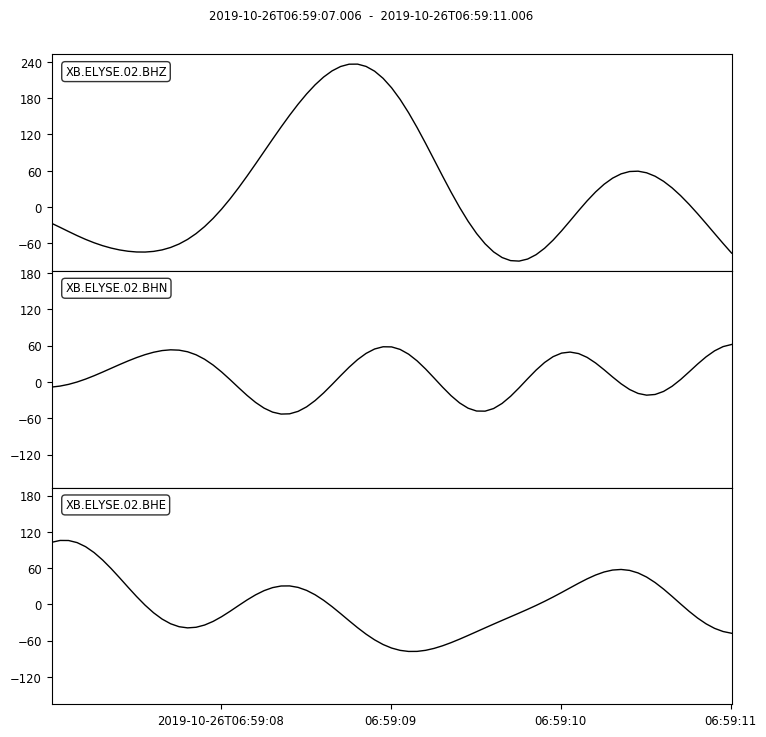

In [27]:
stP = stf.slice(starttime=begin-1,endtime=begin+3)
stS = stf.slice(starttime=end-5, endtime=end+15)
print(stP)
print(stS)
stP.plot();

In [28]:
scale = 1/200
hhe = scale * stP[0].data
hhn = scale * stP[1].data

tvall = []
alpha = np.arange(0,360,1)

# calculate Energy on channels oriented in the a direction, for all a in alpha:
# angle a is relative to orientation of channels 1 and 2.
# c1 is the x-axis, c2 is the y-axis
for a in alpha:
    hhT,hhR = rotate(hhe,hhn,a)
    Tenergy = np.dot(hhT,hhT)
    tvall.append(Tenergy)
    
tval = np.array(tvall) 
mina = alpha[np.argmin(tval)]

mina_guess = tval[np.where(alpha == mina)]
print(mina_guess)

#angle at which the energy is minimized
print('optimal angle = ',mina,' or ',mina-180)
thetat = str(mina); thetalt = str(mina-180)

[ 2.22169871]
optimal angle =  110  or  -70


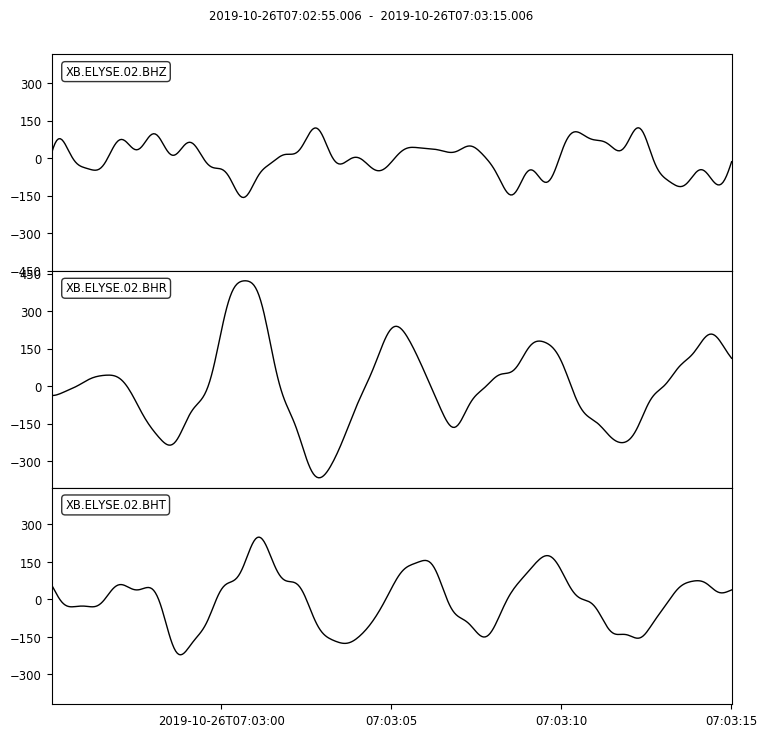

In [29]:
hhe = stS[0].data
hhn = stS[1].data
hhT,hhR = rotate(hhe,hhn,290)

streamRT = stS.copy()
streamRT[0].data = hhT
streamRT[1].data = hhR
streamRT[0].stats.component = 'T'
streamRT[1].stats.component = 'R'

streamRT.plot();

# S0183a

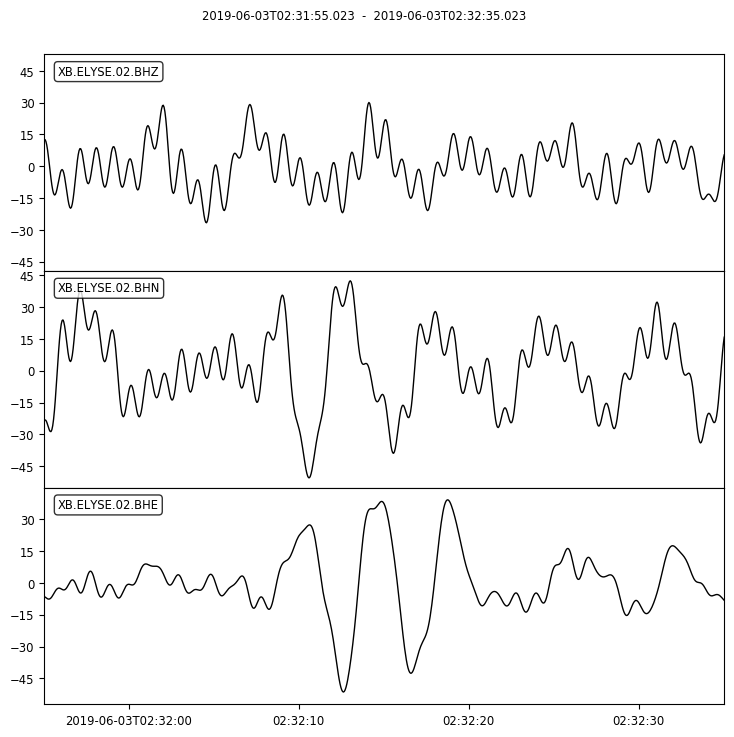

In [22]:
begin = UTCDateTime('2019-06-03T02:27:49')  # p-wave arrival
end = UTCDateTime('2019-06-03T02:32:15')    # s-wave arrival

st_uvw = waveforms(begin, end, 600)
st_z12 = uvw2enz(st_uvw)

stf = st_z12.copy()
stf.filter('bandpass', freqmin = 0.125, freqmax = 1.0, corners=4, zerophase=True)
stzoom = stf.slice(starttime=end-20, endtime=end+20)
stzoom.plot();

3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-06-03T02:27:48.023000Z - 2019-06-03T02:27:52.023000Z | 20.0 Hz, 81 samples
XB.ELYSE.02.BHN | 2019-06-03T02:27:48.023000Z - 2019-06-03T02:27:52.023000Z | 20.0 Hz, 81 samples
XB.ELYSE.02.BHZ | 2019-06-03T02:27:48.023000Z - 2019-06-03T02:27:52.023000Z | 20.0 Hz, 81 samples
3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-06-03T02:32:10.023000Z - 2019-06-03T02:32:30.023000Z | 20.0 Hz, 401 samples
XB.ELYSE.02.BHN | 2019-06-03T02:32:10.023000Z - 2019-06-03T02:32:30.023000Z | 20.0 Hz, 401 samples
XB.ELYSE.02.BHZ | 2019-06-03T02:32:10.023000Z - 2019-06-03T02:32:30.023000Z | 20.0 Hz, 401 samples


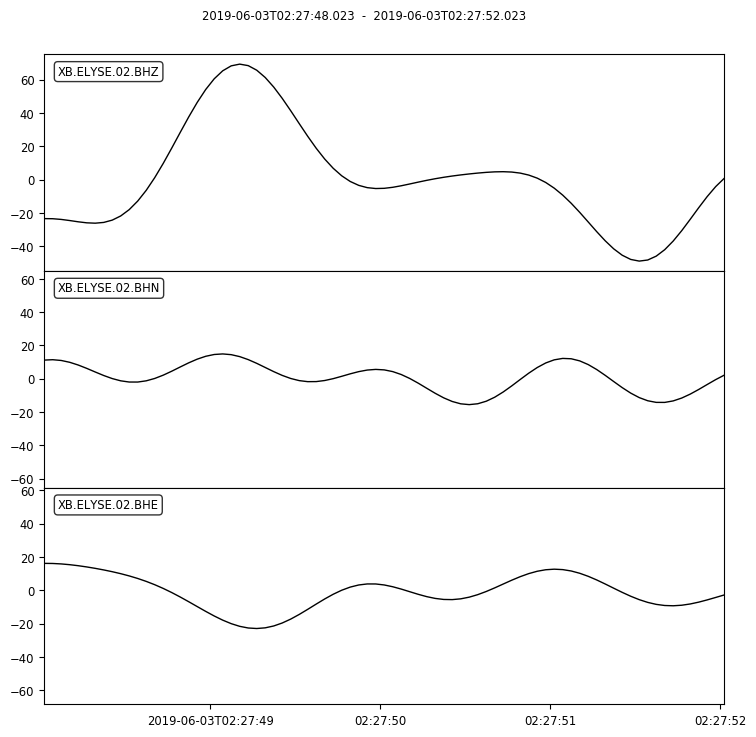

In [23]:
stP = stf.slice(starttime=begin-1,endtime=begin+3)
stS = stf.slice(starttime=end-5, endtime=end+15)
print(stP)
print(stS)
stP.plot();

In [24]:
scale = 1/200
hhe = scale * stP[0].data
hhn = scale * stP[1].data

tvall = []
alpha = np.arange(0,360,1)

# calculate Energy on channels oriented in the a direction, for all a in alpha:
# angle a is relative to orientation of channels 1 and 2.
# c1 is the x-axis, c2 is the y-axis
for a in alpha:
    hhT,hhR = rotate(hhe,hhn,a)
    Tenergy = np.dot(hhT,hhT)
    tvall.append(Tenergy)
    
tval = np.array(tvall) 
mina = alpha[np.argmin(tval)]

mina_guess = tval[np.where(alpha == mina)]
print(mina_guess)

#angle at which the energy is minimized
print('optimal angle = ',mina,' or ',mina-180)
thetat = str(mina); thetalt = str(mina-180)

[ 0.14219829]
optimal angle =  255  or  75


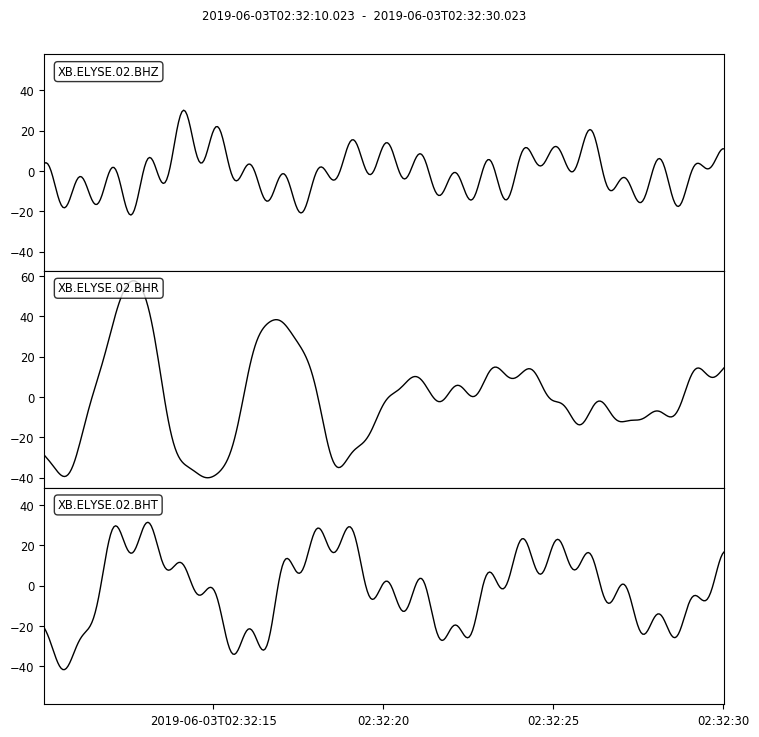

In [25]:
hhe = stS[0].data
hhn = stS[1].data
hhT,hhR = rotate(hhe,hhn,285) #rotate to 180+optimal angle calculated above

streamRT = stS.copy()
streamRT[0].data = hhT
streamRT[1].data = hhR
streamRT[0].stats.component = 'T'
streamRT[1].stats.component = 'R'

streamRT.plot();